**Conclusions** :




*   With cutout validation accuracy improved 1.5% from 86.33 to 87.83
*   Grad CAM highlighted in many images the important areas for the classes that are being predicted. 
*   After cutout the are of importance has moved from irrelevant positions to more relevant positions.





In [1]:
from keras import backend as K
import keras.models
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('../content/drive/', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ../content/drive/


In [0]:
import os
#os.listdir('../content/drive/My Drive/')

In [6]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


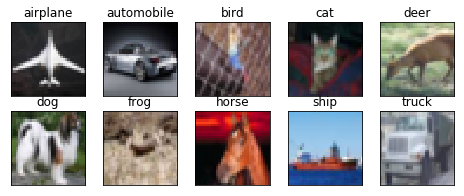

In [7]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [11]:
# 6B model - This is to get base accuracy before cutout
# Define the model
model = Sequential()

x=model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3))) # 32x32 x48
x=model.add(BatchNormalization())
x=model.add(Activation('relu'))
x=model.add(Dropout(0.1))

model.add(Convolution2D(48, 3, 3)) # 30x30 x48
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(2, 2))) #15 x15 x48


model.add(Convolution2D(96, 3, 3, border_mode='same')) #15x15 x96
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
          
model.add(Convolution2D(96, 3, 3)) # 13x13 x96
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2))) #6x6x96

model.add(Convolution2D(192, 3, 3, border_mode='same')) #6x6x192
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))

model.add(Convolution2D(192, 3, 3)) #4x4x192
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))

model.add(Convolution2D(10, 4, 4))
model.add(BatchNormalization()) 
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Convolution2D(10, 1, 1, border_mode='same'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0717 12:30:32.624094 139752369432448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
W0717 12:30:32.675331 139752369432448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 12:30:32.685350 139752369432448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 12:30:32.

In [0]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='../content/drive/My Drive/model_before_cutout.h5', monitor='val_acc', mode='auto', verbose = 1, save_best_only=True)
lr_reducer = ReduceLROnPlateau(monitor='val_acc',factor=0.8, cooldown=0, patience=5, min_lr=0.5e-9,verbose = 1)



# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 48)        0         
__________

**Model without Cutout**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 30s 76ms/step - loss: 1.7062 - acc: 0.3973 - val_loss: 1.5521 - val_acc: 0.5576

Epoch 00001: val_acc improved from -inf to 0.55760, saving model to ../content/drive/My Drive/model_before_cutout.h5
Epoch 2/100
390/390 [==============================] - 28s 73ms/step - loss: 1.5681 - acc: 0.4491 - val_loss: 1.4121 - val_acc: 0.5783

Epoch 00002: val_acc improved from 0.55760 to 0.57830, saving model to ../content/drive/My Drive/model_before_cutout.h5
Epoch 3/100
390/390 [==============================] - 28s 72ms/step - loss: 1.4817 - acc: 0.4815 - val_loss: 1.0968 - val_acc: 0.6956

Epoch 00003: val_acc improved from 0.57830 to 0.69560, saving model to ../content/drive/My Drive/model_before_cutout.h5
Epoch 4/100
390/390 [==============================] - 28s 72ms/step - loss: 1.4158 - acc: 0.5060 - val_loss: 1.2498 - val_acc: 0.6311

Epoch 00004: val_acc did not improve from 0.69560
Epoch 5/100
390/390 [============================

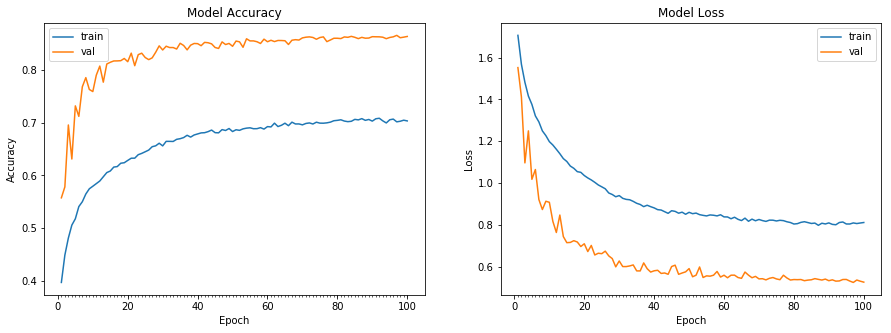

Accuracy on test data is: 86.33


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), callbacks=[checkpointer,lr_reducer],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [13]:
model =keras.models.load_model('../content/drive/My Drive/model_before_cutout.h5')

W0717 12:31:14.379165 139752369432448 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
score = model.evaluate(test_features, test_labels, batch_size=128)
print (score[1])

10000/10000 [==============================] - 4s 427us/step
0.8654


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


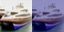

 
101


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


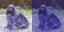

 
201


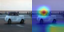

 
501


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


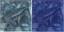

 
901


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


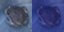

 
1001


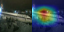

 
1501


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


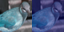

 
1601


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


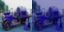

 
2001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


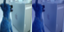

 
4001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


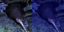

 
5001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


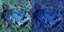

 
6001


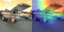

 
7001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


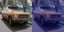

 
8001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


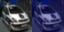

 
9001


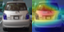

 
9999


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


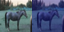

In [15]:
import cv2
from google.colab.patches import cv2_imshow

(trainX, trainy), (testX, testy) = cifar10.load_data()

images = [1,101,201,501,901,1001,1501,1601,2001,4001,5001,6001,7001,8001,9001,9999]
for j in images:
  x = testX[j]
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x,batch_size=1)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_6")


  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(192):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  img = (testX[j])
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  #cv2_imshow(img)
  #cv2_imshow(superimposed_img)
  concatimg = cv2.hconcat([img,superimposed_img])
  # Display the concatenated image
  print (j)
  cv2_imshow(concatimg)
  cv2.waitKey(0)
  print (" ")
  j = j + 1


* Using Cutout

In [16]:
# Define model again and use cutout
from keras import regularizers
# Define the model
model = Sequential()
model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3))) # 32x32 x48
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Convolution2D(48, 3, 3)) # 30x30 x48
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(2, 2))) #15 x15 x48


model.add(Convolution2D(96, 3, 3, border_mode='same')) #15x15 x96
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
          
model.add(Convolution2D(96, 3, 3)) # 13x13 x96
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2))) #6x6x96

model.add(Convolution2D(192, 3, 3, border_mode='same')) #6x6x192
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))

model.add(Convolution2D(192, 3, 3)) #4x4x192
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))

model.add(Convolution2D(10, 4, 4))
model.add(BatchNormalization()) 
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Convolution2D(10, 1, 1, border_mode='same'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call 

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_10 (Activation)   (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 48)        0         
__________

In [0]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

checkpointer1 = ModelCheckpoint(filepath='../content/drive/My Drive/model_after_cutout.h5', monitor='val_acc', mode='auto', verbose = 1, save_best_only=True)
lr_reducer1 = ReduceLROnPlateau(monitor='val_acc',factor=0.8, cooldown=0, patience=5, min_lr=0.5e-9,verbose = 1)



# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

**Model with Cutout**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=100)`
  del sys.path[0]


Epoch 1/100
390/390 [==============================] - 32s 81ms/step - loss: 2.0883 - acc: 0.2489 - val_loss: 1.8178 - val_acc: 0.4089

Epoch 00001: val_acc improved from -inf to 0.40890, saving model to ../content/drive/My Drive/model_after_cutout.h5
Epoch 2/100
390/390 [==============================] - 29s 75ms/step - loss: 1.8213 - acc: 0.3381 - val_loss: 1.5104 - val_acc: 0.5308

Epoch 00002: val_acc improved from 0.40890 to 0.53080, saving model to ../content/drive/My Drive/model_after_cutout.h5
Epoch 3/100
390/390 [==============================] - 29s 74ms/step - loss: 1.6919 - acc: 0.3901 - val_loss: 1.3926 - val_acc: 0.6038

Epoch 00003: val_acc improved from 0.53080 to 0.60380, saving model to ../content/drive/My Drive/model_after_cutout.h5
Epoch 4/100
390/390 [==============================] - 29s 73ms/step - loss: 1.6090 - acc: 0.4203 - val_loss: 1.2656 - val_acc: 0.6285

Epoch 00004: val_acc improved from 0.60380 to 0.62850, saving model to ../content/drive/My Drive/model

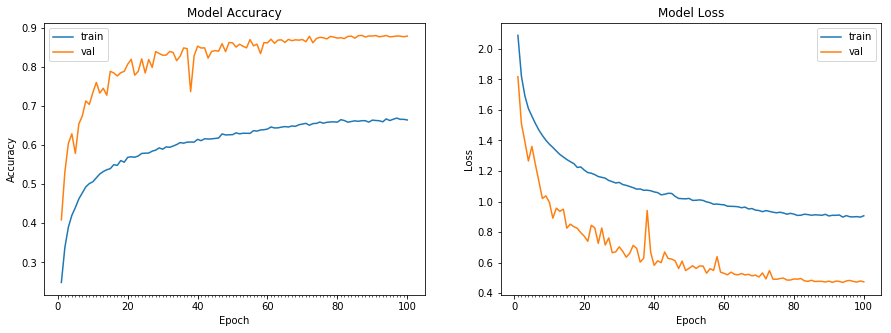

Accuracy on test data is: 87.82


In [20]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), callbacks=[checkpointer1,lr_reducer1],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
model=keras.models.load_model('../content/drive/My Drive/model_after_cutout.h5')

In [22]:
score = model.evaluate(test_features, test_labels, batch_size=128)
print (score[1])

10000/10000 [==============================] - 2s 232us/step
0.88


***Model with Cutout : Grad CAM results ***

1


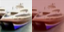

 
101


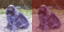

 
201


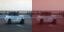

 
501


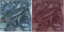

 
901


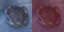

 
1001


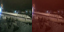

 
1501


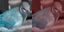

 
1601


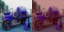

 
2001


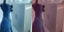

 
4001


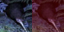

 
5001


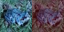

 
6001


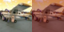

 
7001


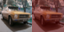

 
8001


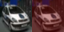

 
9001


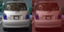

 
9999


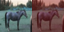

In [27]:
import cv2
from google.colab.patches import cv2_imshow

images = [1,101,201,501,901,1001,1501,1601,2001,4001,5001,6001,7001,8001,9001,9999]
for j in images:
  x = testX[j]
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x,batch_size=1)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_16") 

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(10):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap) 
  img = (testX[j])
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  #cv2_imshow(img)
  #cv2_imshow(superimposed_img)
  concatimg = cv2.hconcat([img,superimposed_img])
  # Display the concatenated image
  print (j)
  cv2_imshow(concatimg)
  cv2.waitKey(0)
  print (" ")
  j = j + 1